In [92]:
pip install lofo-importance

In [93]:
import numpy as np
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from lightgbm import LGBMClassifier

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Convert field names to dict for easy access.
# Can be hard coded 
# 
fields_path = '../../content/training-validation-2/fields.csv'  
fields_df = pd.read_csv(fields_path)
fields_df.columns = ['name', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']

fields_dict = {}
fields_dictv2 = {}

for idx in range(fields_df.shape[0]):
    name = fields_df.loc[idx, 'name']

    _fields = []
    
    for f in fields_df.columns[1:]:
        if not (str(fields_df.loc[idx, f]) == 'nan'):
            _fields.append(name + "_" + str(fields_df.loc[idx, f]))
    
    fields_dict[idx] = {'name': fields_df.loc[idx, 'name'] , 'fields': _fields}
    fields_dictv2[name] = _fields
    
fields_dict

{0: {'fields': ['CpuTemperature_vMax',
   'CpuTemperature_vMin',
   'CpuTemperature_vStd',
   'CpuTemperature_value'],
  'name': 'CpuTemperature'},
 1: {'fields': ['DurationPickToPick_vCnt',
   'DurationPickToPick_vFreq',
   'DurationPickToPick_vMax',
   'DurationPickToPick_vMin',
   'DurationPickToPick_vStd',
   'DurationPickToPick_vTrend',
   'DurationPickToPick_value'],
  'name': 'DurationPickToPick'},
 2: {'fields': ['DurationRobotFromFeederToTestBench_vCnt',
   'DurationRobotFromFeederToTestBench_vFreq',
   'DurationRobotFromFeederToTestBench_vMax',
   'DurationRobotFromFeederToTestBench_vMin',
   'DurationRobotFromFeederToTestBench_vStd',
   'DurationRobotFromFeederToTestBench_vTrend',
   'DurationRobotFromFeederToTestBench_value'],
  'name': 'DurationRobotFromFeederToTestBench'},
 3: {'fields': ['DurationRobotFromTestBenchToFeeder_vCnt',
   'DurationRobotFromTestBenchToFeeder_vFreq',
   'DurationRobotFromTestBenchToFeeder_vMax',
   'DurationRobotFromTestBenchToFeeder_vMin',
   '

In [11]:
feature_list = [fields_dict[f]['name'] for f in list(fields_dict)[29:35]]
feature_list

['LightBarrierPassiveTaskDuration1b',
 'LightBarrierPassiveTaskDuration2',
 'LightBarrierTaskDuration',
 'NumberEmptyFeeder',
 'NumberFuseDetected',
 'NumberFuseEstimated']

In [12]:
feature_list_regex= "|".join(["^"+f for f in feature_list])
feature_list_regex

'^LightBarrierPassiveTaskDuration1b|^LightBarrierPassiveTaskDuration2|^LightBarrierTaskDuration|^NumberEmptyFeeder|^NumberFuseDetected|^NumberFuseEstimated'

In [13]:
# import data
data_df_1 = pd.read_csv("../content/training-validation-1.csv")
data_df_2 = pd.read_csv("../content/training-validation-2.csv")
train_df = pd.concat([data_df_1, data_df_2], axis=0) # Merge data frames


In [16]:
feature_set = ['LightBarrierPassiveTaskDuration1b', 'LightBarrierPassiveTaskDuration2',
                'LightBarrierTaskDuration', 'NumberEmptyFeeder', 'NumberFuseDetected','NumberFuseEstimated']

In [17]:
feature_set_all = list(filter(lambda x: x.startswith(tuple(feature_set)), train_df.columns))

In [18]:
df = train_df[["class", "run"] + feature_set_all]
df.head()

,class,run,LightBarrierPassiveTaskDuration1b_vCnt,LightBarrierPassiveTaskDuration1b_vFreq,LightBarrierPassiveTaskDuration2_vCnt,LightBarrierPassiveTaskDuration2_vFreq,LightBarrierTaskDuration_vCnt,LightBarrierTaskDuration_vFreq,NumberEmptyFeeder_vCnt,NumberFuseDetected_vCnt,NumberFuseDetected_vFreq,NumberFuseDetected_vMax,NumberFuseDetected_vMin,NumberFuseDetected_vStd,NumberFuseDetected_vTrend,NumberFuseDetected_value,NumberFuseEstimated_vCnt,NumberFuseEstimated_vFreq,NumberFuseEstimated_vMax,NumberFuseEstimated_vMin,NumberFuseEstimated_vStd,NumberFuseEstimated_vTrend,NumberFuseEstimated_value
0,0,18,0,0,0,0,0,0,1,1,1.31364,33.0,33.0,0.0,NaN,33.0,2,1.036118,68.0,64.0,2.0,4.0,66.0
1,0,18,0,0,0,0,0,0,0,0,0.00000,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,NaN,NaN
2,0,18,0,0,0,0,0,0,0,0,0.00000,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,NaN,NaN
3,0,18,0,0,0,0,0,0,0,0,0.00000,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,NaN,NaN
4,0,18,0,0,0,0,0,0,0,0,0.00000,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,NaN,NaN


In [19]:
def get_nan_info_table(data, fields):
    
    class_ = data["class"].iloc[0]
    run_ = data["run"].iloc[0]
    field_df = data[fields]
    # print(field_df.isnull().sum())
    
    return field_df.isnull().sum().T

In [20]:
nan_info2_table = df.groupby(["class", "run"]).apply(get_nan_info_table, feature_set_all)
# nan_info_table

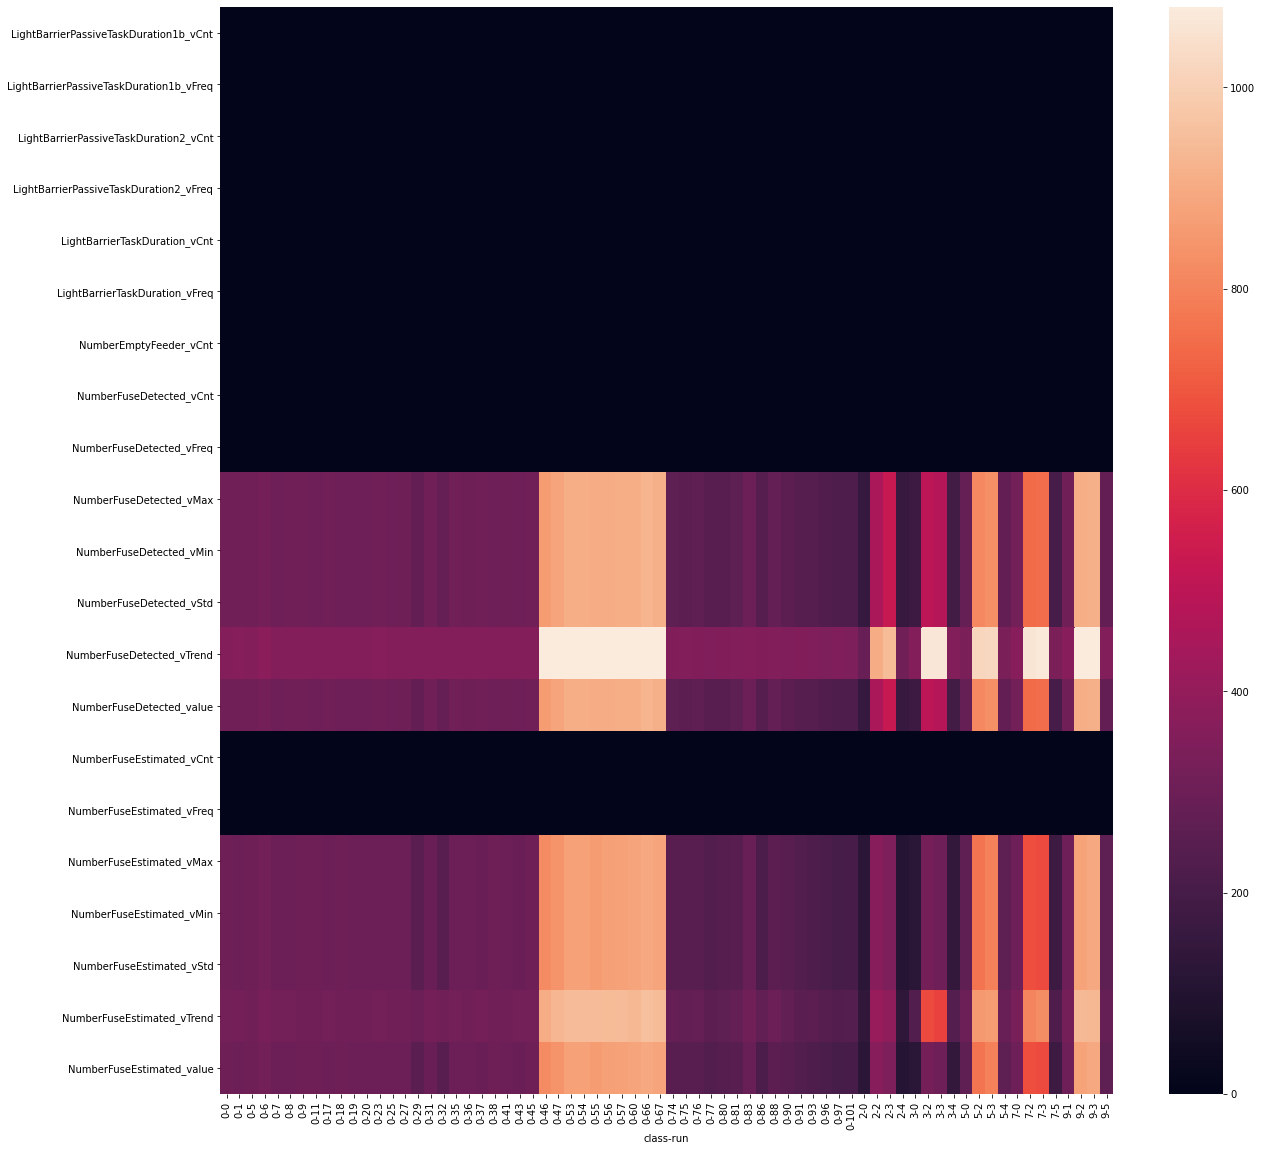

In [21]:
# nan_info2_table = nan_info2_table.reset_index(["run"]).reset_index(drop=True).set_index("run")
# nan_info2_table

plt.figure (figsize=(20, 20))
sns.heatmap(nan_info2_table.T, annot=False)

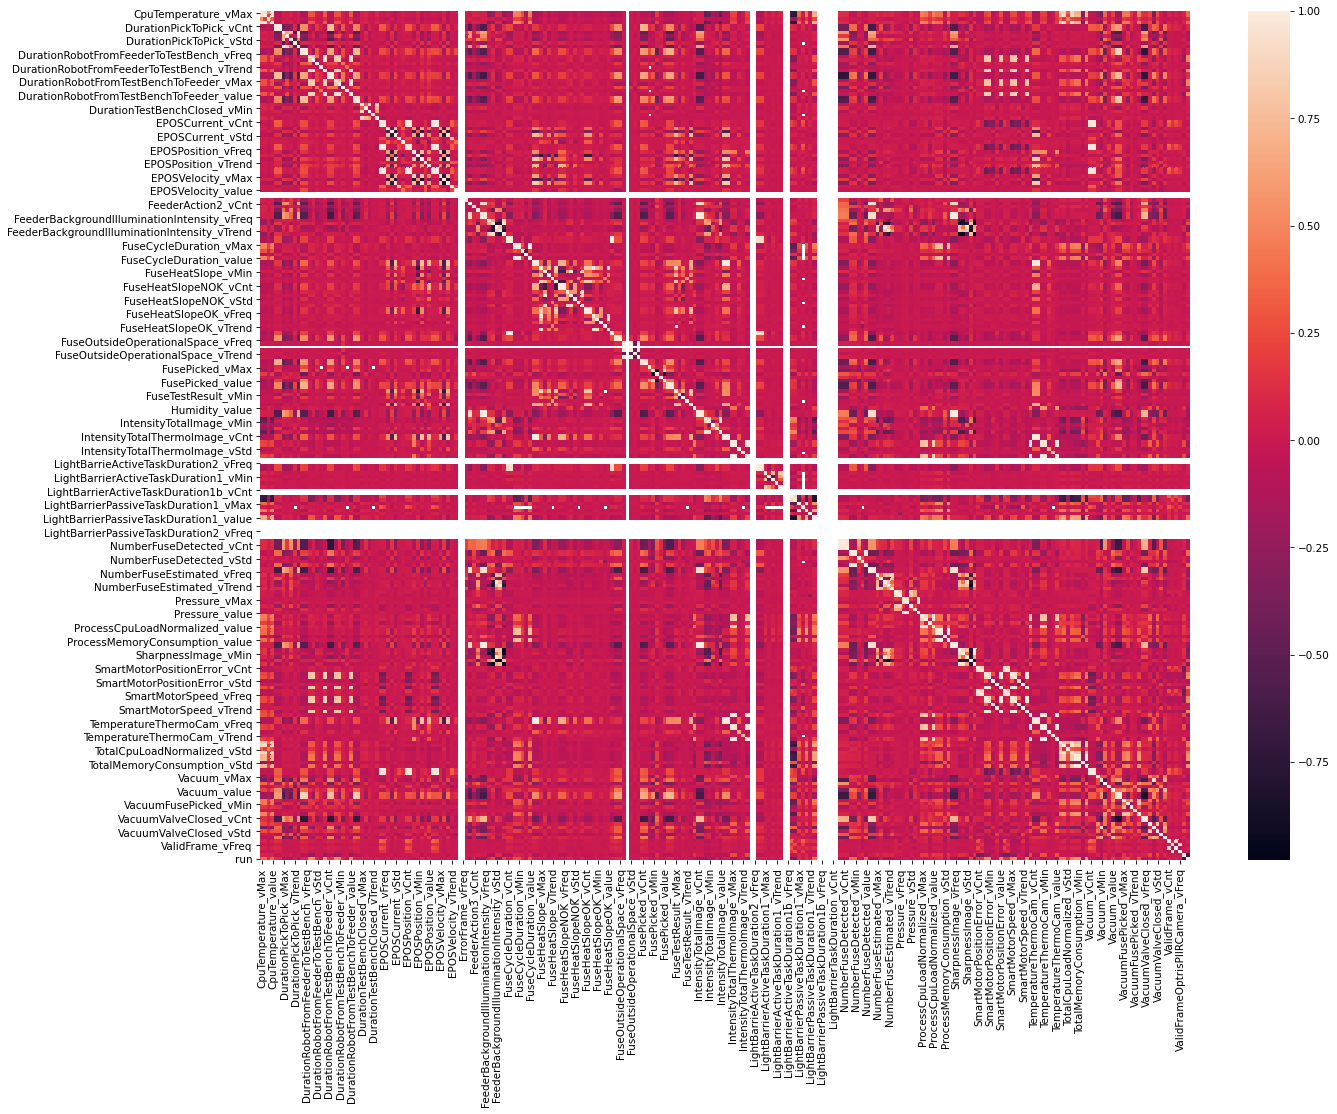

In [22]:
fig = plt.figure(figsize=(20,15), dpi=75)
sns.heatmap(train_df.corr(),annot=False)

In [23]:
nan_info2_table.style.background_gradient(cmap='Blues')

In [24]:
df_ori = df.copy(deep=True)

In [25]:
df_ori.shape

(39611, 23)

In [56]:
df = df_ori.copy()
df = df.dropna(thresh=int(df.shape[0] * 0.7), axis=1)  # Drop column if it does not have at least x values that are **not** NaN
print("col: ", df.shape)

col:  (39611, 13)


In [57]:
removed_features_1 = list(set(df_ori.columns).difference(df.columns))
print(removed_features_1)

['NumberFuseEstimated_vStd', 'NumberFuseDetected_vStd', 'NumberFuseEstimated_vTrend', 'NumberFuseEstimated_vMax', 'NumberFuseDetected_vMax', 'NumberFuseDetected_value', 'NumberFuseDetected_vMin', 'NumberFuseEstimated_value', 'NumberFuseEstimated_vMin', 'NumberFuseDetected_vTrend']


In [58]:
df_remain = df.copy(deep=True)

In [59]:
for column in df.columns:
    if column not in ["class", "run"]:
        if (len(df[column].unique()) == 1) or (df[column].isnull().all()):
            df.drop(column, inplace=True, axis=1)
            # print(column, "droped-unique")

        else:
            zero_rows = df.loc[df[column] == float(0)]
            if zero_rows.shape[0] >= df.shape[0] * 50:
                df.drop(column, inplace=True, axis=1)
                # print(column, "droped-zero")

In [60]:
removed_features_2 = list(set(df_remain.columns).difference(df.columns))
print(removed_features_2)

['LightBarrierPassiveTaskDuration2_vCnt', 'LightBarrierTaskDuration_vCnt', 'LightBarrierPassiveTaskDuration1b_vFreq', 'LightBarrierPassiveTaskDuration1b_vCnt', 'LightBarrierPassiveTaskDuration2_vFreq', 'LightBarrierTaskDuration_vFreq']


In [63]:
remain_features_set = list(set(feature_set_all).difference(removed_features_1 + removed_features_2))
remain_base_features_set = list(set([col.split('_')[0] for col in remain_features_set]))

len(remain_base_features_set), len(remain_features_set), np.array(remain_base_features_set), 

(3,
 5,
 array(['NumberEmptyFeeder', 'NumberFuseEstimated', 'NumberFuseDetected'],
       dtype='<U19'))

In [67]:
import random
selected_class_zero_runs = random.sample(set(df.loc[df["class"] == 0, "run"]), 5)
selected_class_zero_runs

[75, 5, 77, 45, 31]

In [68]:
def data_visualization(data, name, fields):

    # https://stackoverflow.com/questions/46063379/pandas-secondary-axis
    
    class_ = data["class"].iloc[0]
    run_ = data["run"].iloc[0]
    field_df = data[fields]
    
    if (class_ == 0) and (run_ not in selected_class_zero_runs):
        return
    
    print("class_{}_run_{}".format(class_, run_))

    
    print(field_df.isnull().sum())
    plt.figure (figsize=(18, 5))
            
    if name + "_vStd" in fields:
        fields_ = fields.copy()
        fields_.remove(name + "_vStd")

        ax = field_df[[name + "_vStd"]].reset_index(drop=True).plot(color='yellow', figsize=(18,5))
        field_df[fields_].reset_index(drop=True).plot(ax=ax, secondary_y=True,  figsize=(18, 5))

    else:
        field_df.reset_index(drop=True).plot()

    plt.xlabel("Cycles")
    plt.ylabel(name)
    plt.title("{} Class_{} Run_{}".format(name, class_, run_))
    plt.show()
    plt.clf()

class_0_run_5
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 1296x360 with 0 Axes>

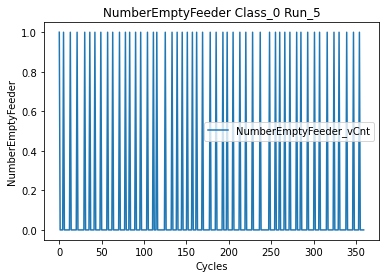

class_0_run_31
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

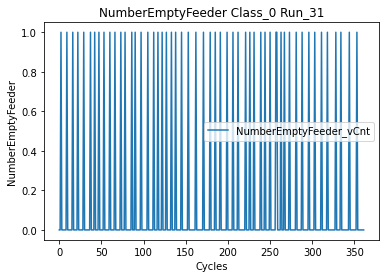

class_0_run_45
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

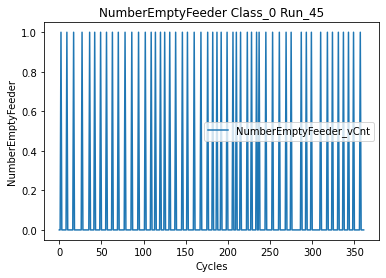

class_0_run_75
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

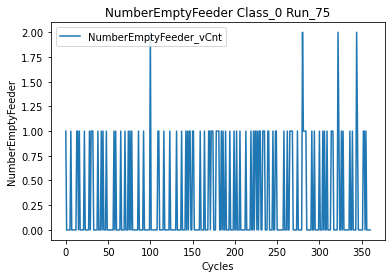

class_0_run_77
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

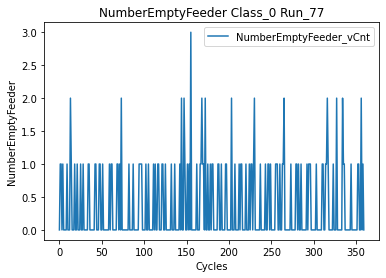

class_2_run_0
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

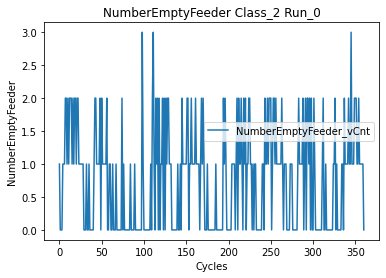

class_2_run_2
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

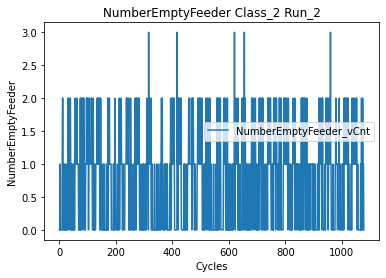

class_2_run_3
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

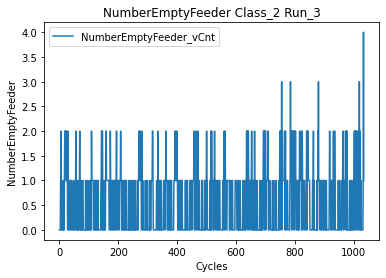

class_2_run_4
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

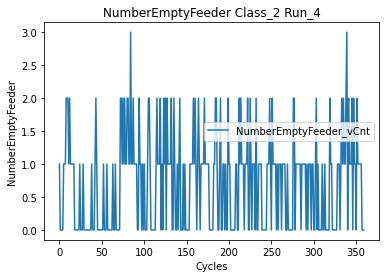

class_3_run_0
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

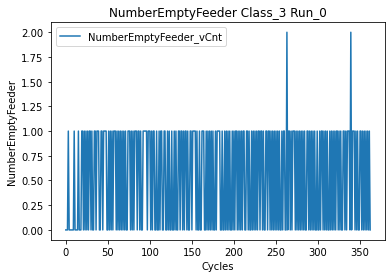

class_3_run_2
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

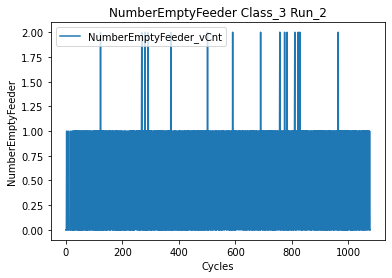

class_3_run_3
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

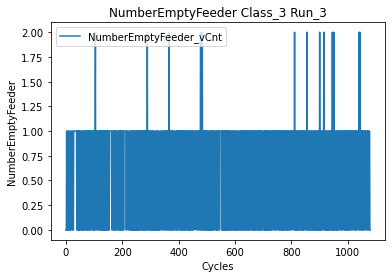

class_3_run_4
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

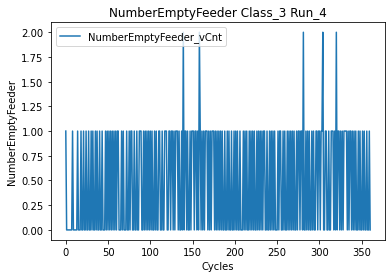

class_5_run_0
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

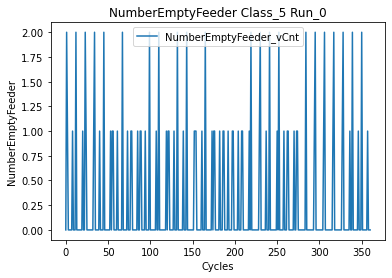

class_5_run_2
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

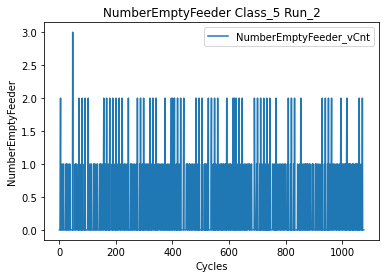

class_5_run_3
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

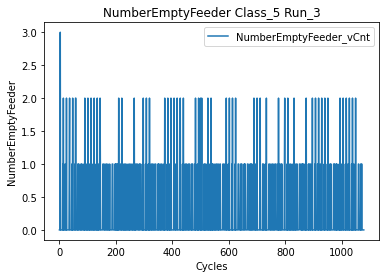

class_5_run_4
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

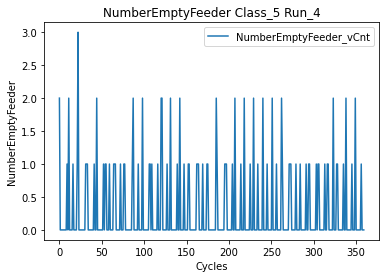

class_7_run_0
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

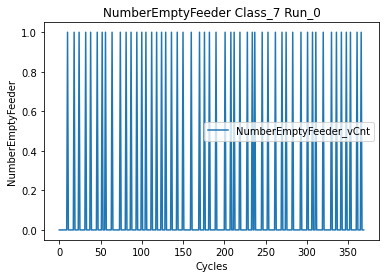

class_7_run_2
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

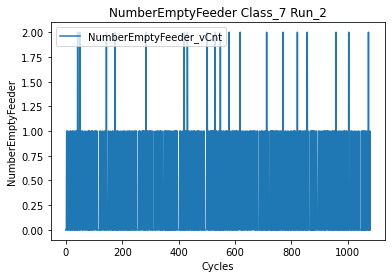

class_7_run_3
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

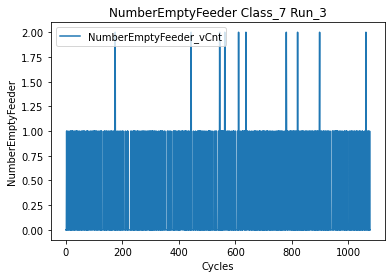

class_7_run_5
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

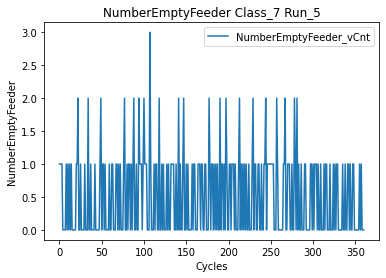

class_9_run_1
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

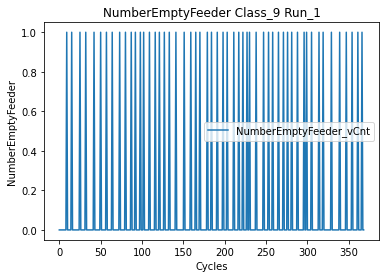

class_9_run_2
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

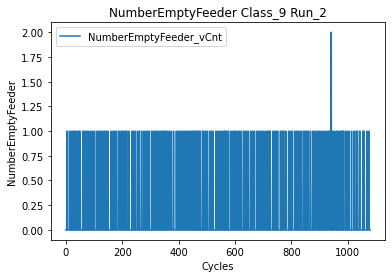

class_9_run_3
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

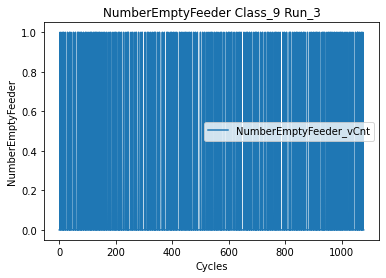

class_9_run_5
NumberEmptyFeeder_vCnt    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

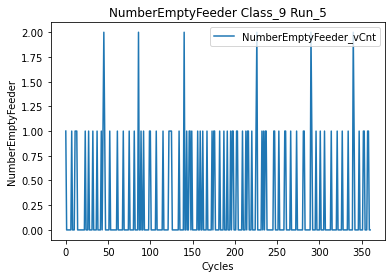

<Figure size 432x288 with 0 Axes>

In [69]:
for f in fields_dict:
    name = fields_dict[f]['name']
    fields = fields_dict[f]['fields']

    if name not in remain_base_features_set[0]:
      continue

    fields = list(set(fields).intersection(set(remain_features_set)))
    df.groupby(["class", "run"]).apply(data_visualization, name, fields)

class_0_run_5
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 1296x360 with 0 Axes>

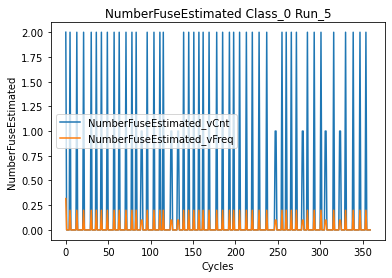

class_0_run_31
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

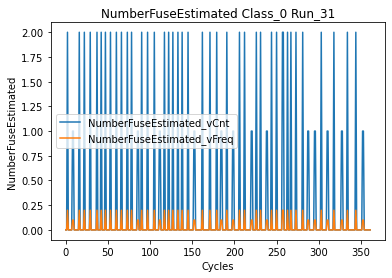

class_0_run_45
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

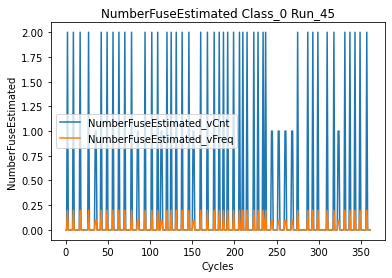

class_0_run_75
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

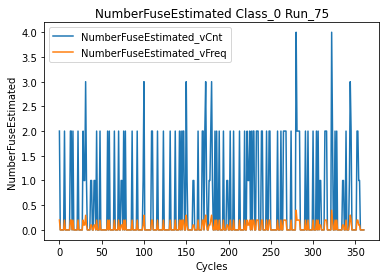

class_0_run_77
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

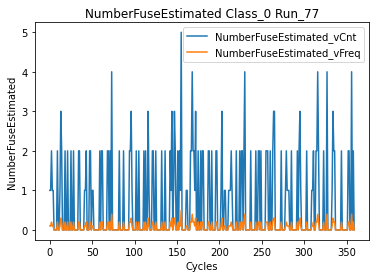

class_2_run_0
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

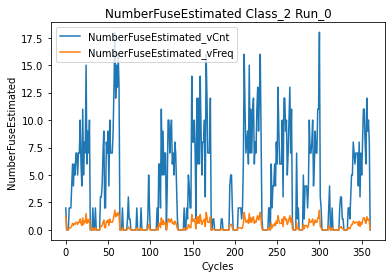

class_2_run_2
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

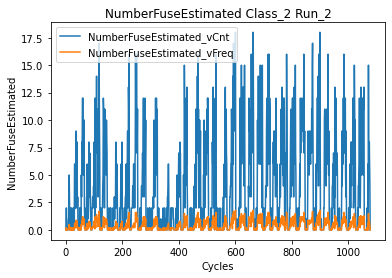

class_2_run_3
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

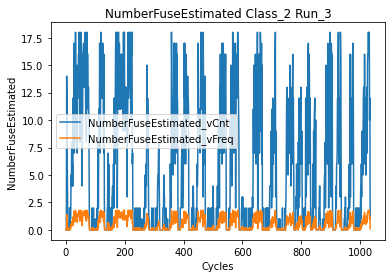

class_2_run_4
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

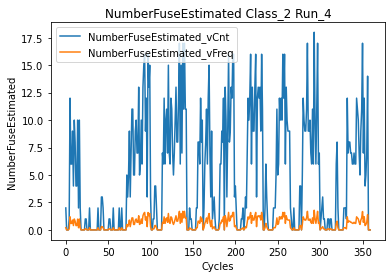

class_3_run_0
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

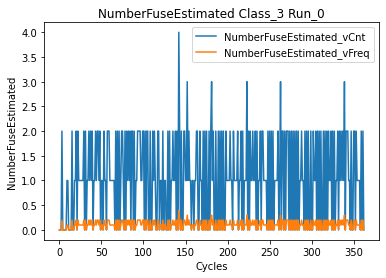

class_3_run_2
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

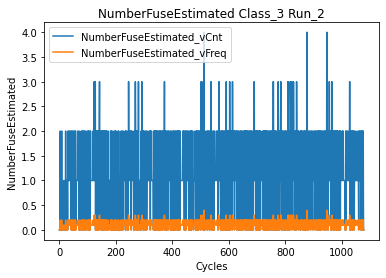

class_3_run_3
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

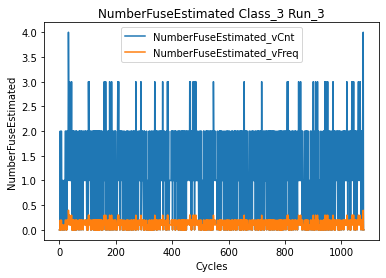

class_3_run_4
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

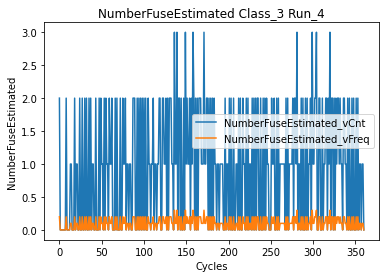

class_5_run_0
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

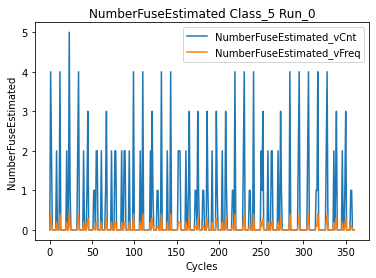

class_5_run_2
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

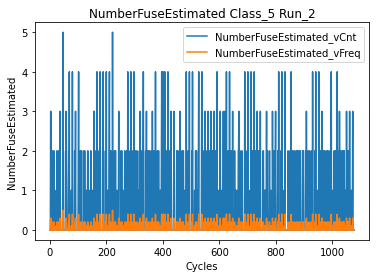

class_5_run_3
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

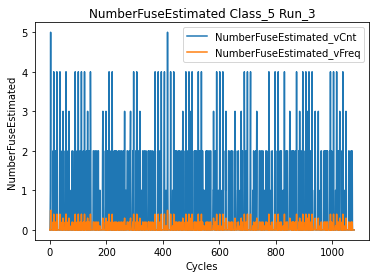

class_5_run_4
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

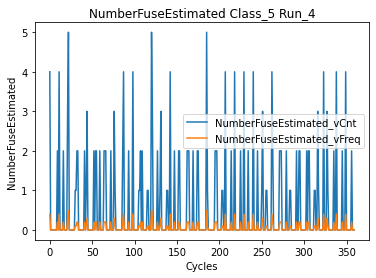

class_7_run_0
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

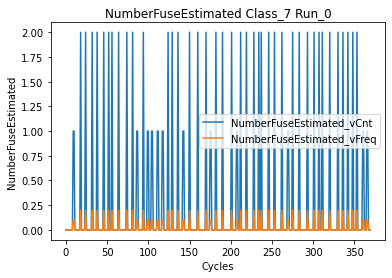

class_7_run_2
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

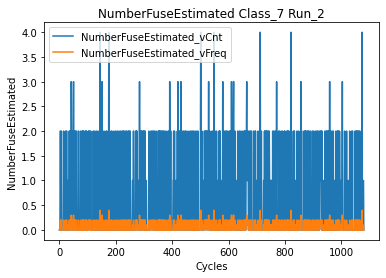

class_7_run_3
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

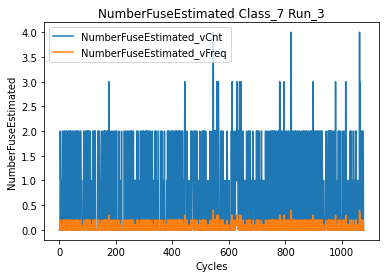

class_7_run_5
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

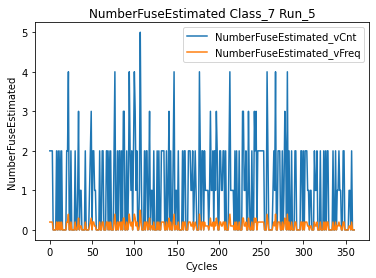

class_9_run_1
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

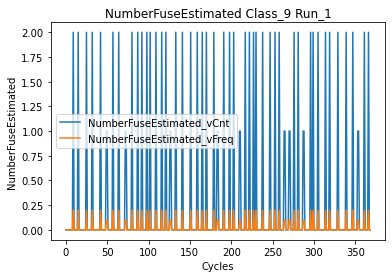

class_9_run_2
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

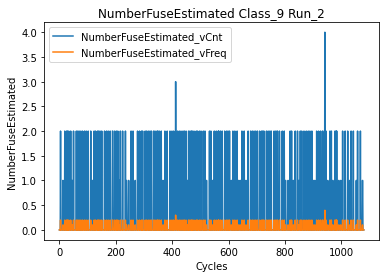

class_9_run_3
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

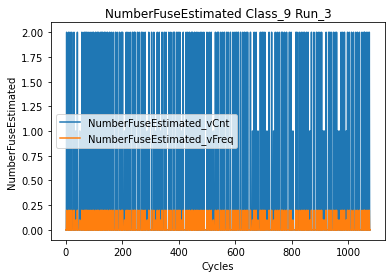

class_9_run_5
NumberFuseEstimated_vCnt     0
NumberFuseEstimated_vFreq    0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

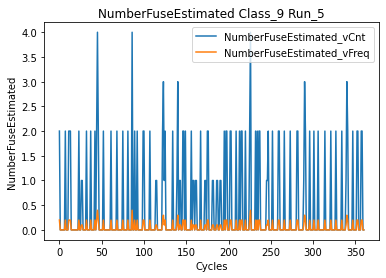

<Figure size 432x288 with 0 Axes>

In [70]:
for f in fields_dict:
    name = fields_dict[f]['name']
    fields = fields_dict[f]['fields']

    if name not in remain_base_features_set[1]:
      continue

    fields = list(set(fields).intersection(set(remain_features_set)))
    df.groupby(["class", "run"]).apply(data_visualization, name, fields)

class_0_run_5
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 1296x360 with 0 Axes>

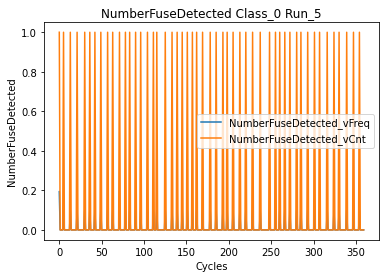

class_0_run_31
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

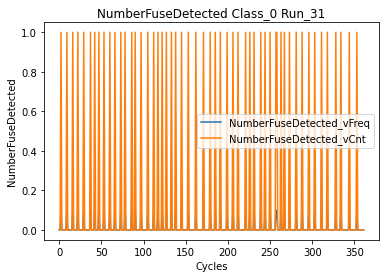

class_0_run_45
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

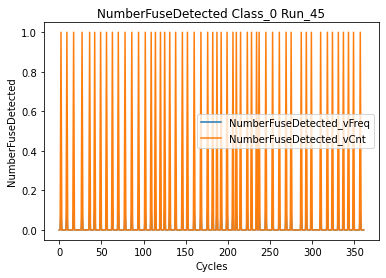

class_0_run_75
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

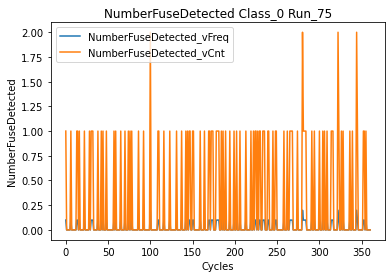

class_0_run_77
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

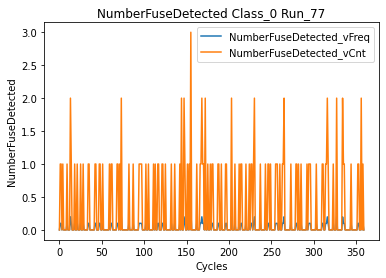

class_2_run_0
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

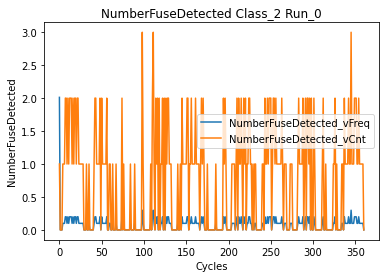

class_2_run_2
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

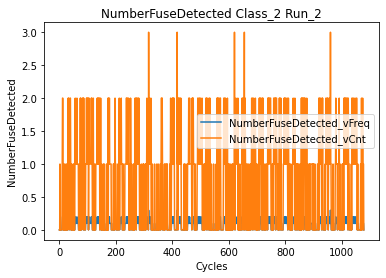

class_2_run_3
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

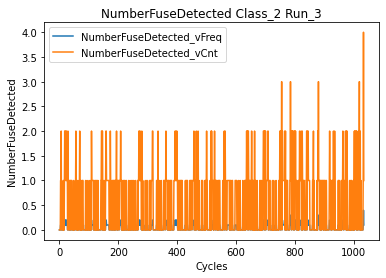

class_2_run_4
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

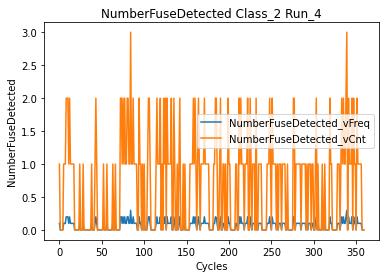

class_3_run_0
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

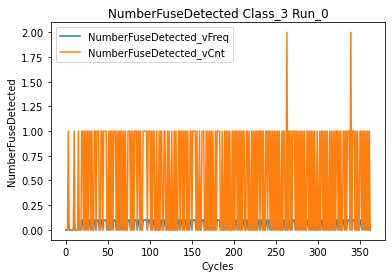

class_3_run_2
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

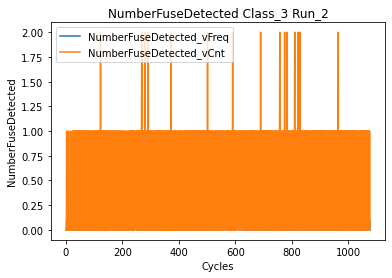

class_3_run_3
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

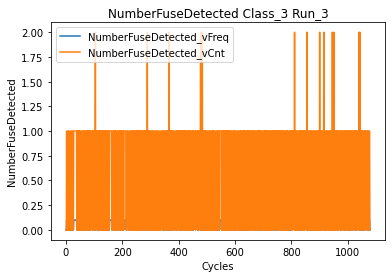

class_3_run_4
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

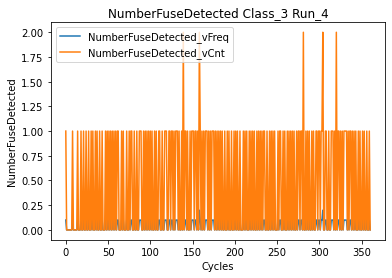

class_5_run_0
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

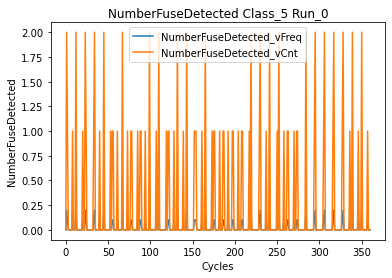

class_5_run_2
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

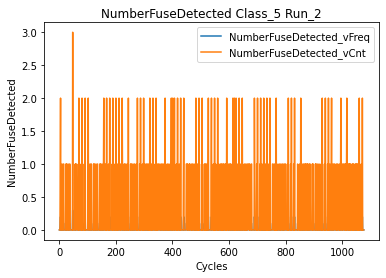

class_5_run_3
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

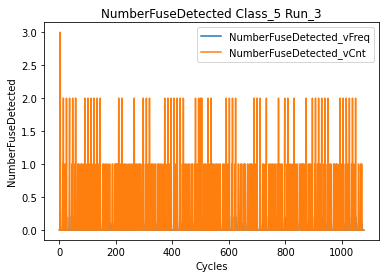

class_5_run_4
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

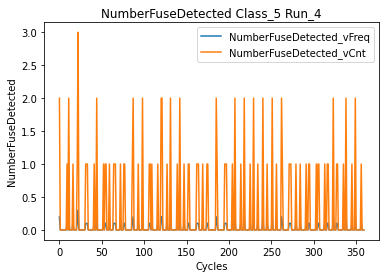

class_7_run_0
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

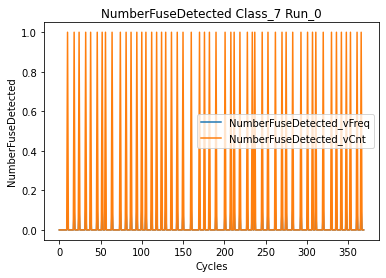

class_7_run_2
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

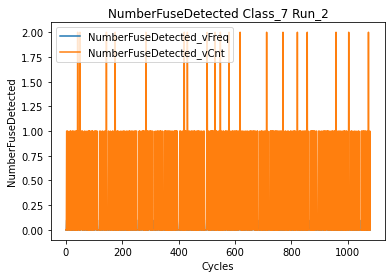

class_7_run_3
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

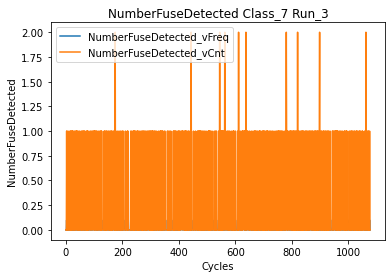

class_7_run_5
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

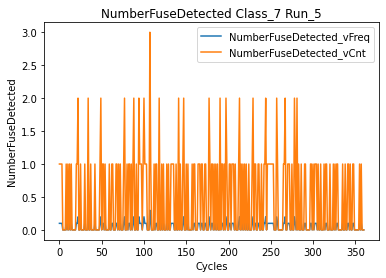

class_9_run_1
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

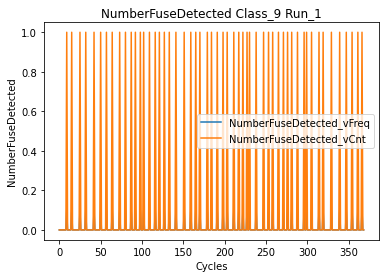

class_9_run_2
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

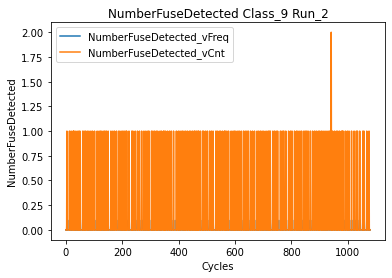

class_9_run_3
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

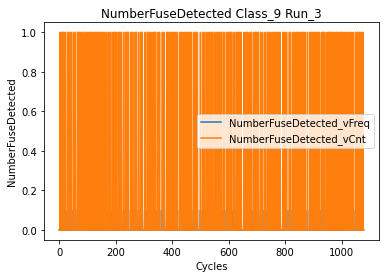

class_9_run_5
NumberFuseDetected_vFreq    0
NumberFuseDetected_vCnt     0
dtype: int64


<Figure size 432x288 with 0 Axes>

<Figure size 1296x360 with 0 Axes>

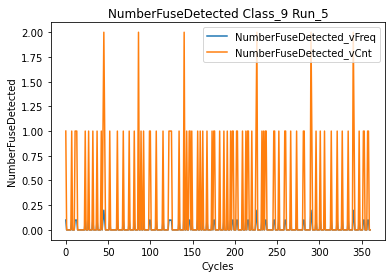

<Figure size 432x288 with 0 Axes>

In [71]:
for f in fields_dict:
    name = fields_dict[f]['name']
    fields = fields_dict[f]['fields']

    if name not in remain_base_features_set[2]:
      continue

    fields = list(set(fields).intersection(set(remain_features_set)))
    df.groupby(["class", "run"]).apply(data_visualization, name, fields)

In [72]:
def fill_nan_values(data, name, fields):

    field_df = data[fields]

    if field_df.isnull().values.any():
        data[fields] = field_df.interpolate(method='linear', limit_direction='both')

    return data[fields]

In [74]:
for f in fields_dict:
    
    name = fields_dict[f]['name']
    fields = fields_dict[f]['fields']
    
    if name not in remain_base_features_set2:
        continue
        
    fields = list(set(fields).intersection(set(remain_features_set)))        
    print("\nname:", name, "fields:", fields)
    df_ = df.groupby(["class", "run"]).apply(fill_nan_values, name, fields)
    df_.reset_index(drop=True, inplace=True)
    df[fields] = df_[fields]


name: NumberEmptyFeeder fields: ['NumberEmptyFeeder_vCnt']

name: NumberFuseDetected fields: ['NumberFuseDetected_vFreq', 'NumberFuseDetected_vCnt']

name: NumberFuseEstimated fields: ['NumberFuseEstimated_vCnt', 'NumberFuseEstimated_vFreq']


In [75]:
df.isnull().sum().any()

False

In [76]:
df

,class,run,NumberEmptyFeeder_vCnt,NumberFuseDetected_vCnt,NumberFuseDetected_vFreq,NumberFuseEstimated_vCnt,NumberFuseEstimated_vFreq
0,0,18,1,1,1.313640,2,1.036118
1,0,18,1,1,0.099831,2,0.199662
2,0,18,0,0,0.000000,0,0.000000
3,0,18,0,0,0.000000,0,0.000000
4,0,18,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...
17971,7,3,0,0,0.000000,0,0.000000
17972,7,3,0,0,0.000000,0,0.000000
17973,7,3,0,0,0.000000,0,0.000000
17974,7,3,0,0,0.000000,0,0.000000


In [77]:
for column in df.columns:
    if column not in ["class", "run"]:
        if (len(df[column].unique()) == 1) or (df[column].isnull().all()):
            df.drop(column, inplace=True, axis=1)
            print(column, "droped-unique")

        else:
            zero_rows = df.loc[df[column] == float(0)]
            if zero_rows.shape[0] >= df.shape[0] * 50:
                df.drop(column, inplace=True, axis=1)
                print(column, "droped-zero")      

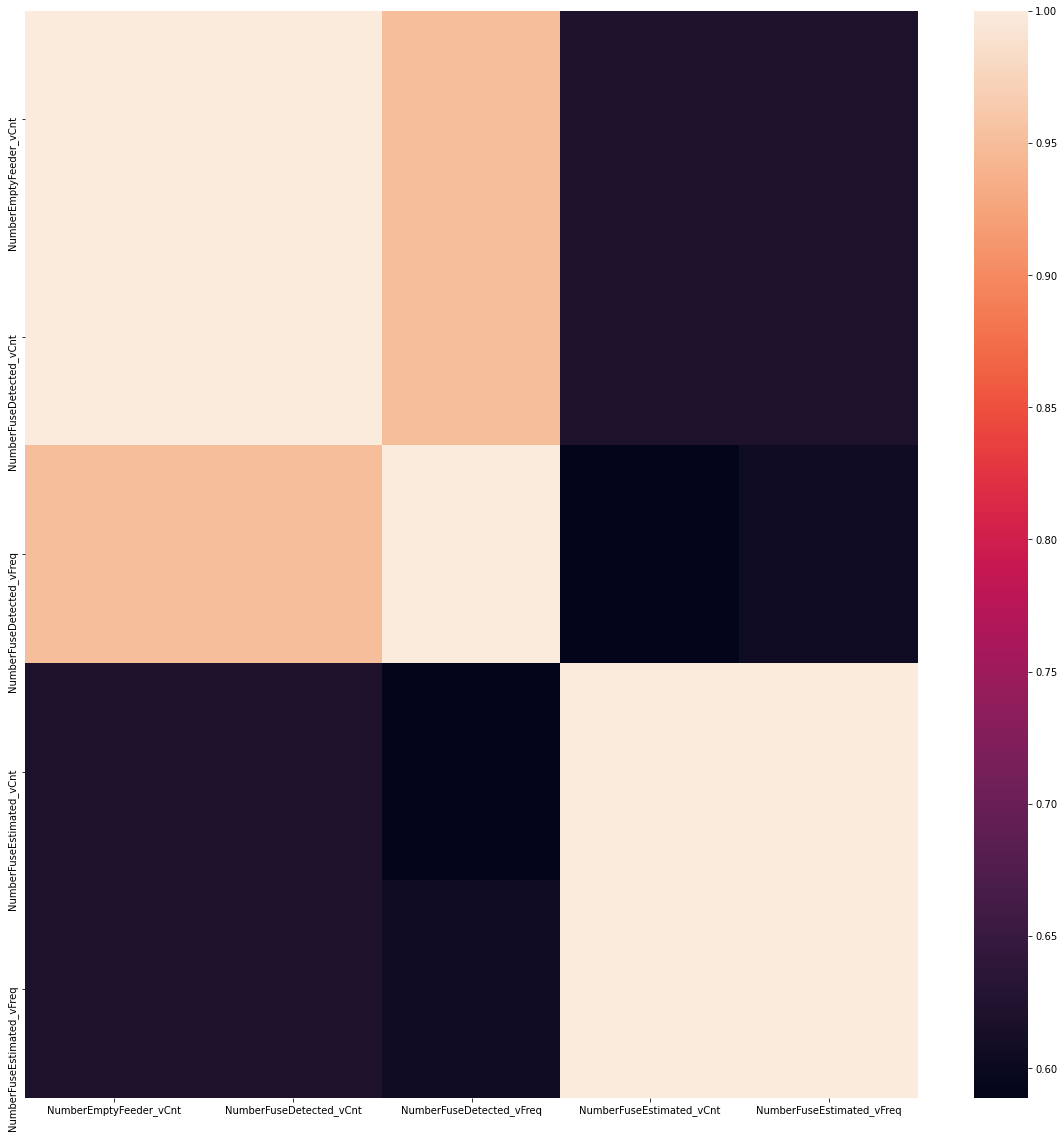

In [78]:
corr = df.drop(["class", "run"], axis=1).corr()
plt.figure (figsize=(20, 20))
sns.heatmap(corr, annot=False)

In [79]:
corr.style.background_gradient(cmap='Blues')

,NumberEmptyFeeder_vCnt,NumberFuseDetected_vCnt,NumberFuseDetected_vFreq,NumberFuseEstimated_vCnt,NumberFuseEstimated_vFreq
NumberEmptyFeeder_vCnt,1.000000,1.000000,0.950319,0.620457,0.620132
NumberFuseDetected_vCnt,1.000000,1.000000,0.950319,0.620457,0.620132
NumberFuseDetected_vFreq,0.950319,0.950319,1.000000,0.588756,0.604617
NumberFuseEstimated_vCnt,0.620457,0.620457,0.588756,1.000000,0.998578
NumberFuseEstimated_vFreq,0.620132,0.620132,0.604617,0.998578,1.000000


In [80]:
df

,class,run,NumberEmptyFeeder_vCnt,NumberFuseDetected_vCnt,NumberFuseDetected_vFreq,NumberFuseEstimated_vCnt,NumberFuseEstimated_vFreq
0,0,18,1,1,1.313640,2,1.036118
1,0,18,1,1,0.099831,2,0.199662
2,0,18,0,0,0.000000,0,0.000000
3,0,18,0,0,0.000000,0,0.000000
4,0,18,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...
17971,7,3,0,0,0.000000,0,0.000000
17972,7,3,0,0,0.000000,0,0.000000
17973,7,3,0,0,0.000000,0,0.000000
17974,7,3,0,0,0.000000,0,0.000000


In [83]:
scaler_cols = list(set(df.columns).difference(["class", "run"]))
len(scaler_cols)

5

In [84]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(df[scaler_cols])
scaler_data = pd.DataFrame(scaler_data, index=df.index, columns=scaler_cols)
scaler_data

,NumberEmptyFeeder_vCnt,NumberFuseEstimated_vCnt,NumberFuseEstimated_vFreq,NumberFuseDetected_vCnt,NumberFuseDetected_vFreq
0,1.381677,0.628277,5.089414,1.381677,23.806150
1,1.381677,0.628277,0.629753,1.381677,1.307943
2,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
3,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
4,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
...,...,...,...,...,...
17971,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
17972,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
17973,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446
17974,-0.569955,-0.434938,-0.434769,-0.569955,-0.542446


In [85]:
pca = PCA(n_components=0.95)

principalComponents = pca.fit_transform(scaler_data)
pc_columns = []
for i in range(1, pca.n_components_ + 1, 1):
    pc_columns.append('PC' + str(i))

pca_data = pd.DataFrame(data=principalComponents, columns=pc_columns, index=scaler_data.index)
pca_data

,PC1,PC2
0,14.593673,-6.028098
1,2.420923,-0.676121
2,-1.146968,0.080172
3,-1.146968,0.080172
4,-1.146968,0.080172
...,...,...
17971,-1.146968,0.080172
17972,-1.146968,0.080172
17973,-1.146968,0.080172
17974,-1.146968,0.080172


In [86]:
train_df = pd.concat([scaler_data, df["class"]], axis=1)
train_df.shape

(39611, 6)

In [87]:
# extract a sample of the data
sample_df = train_df.sample(frac=0.25, random_state=0)

# define the validation scheme
cv = KFold(n_splits=5, shuffle=False, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [95]:
# dataset = Dataset(df=sample_df, target="class", features=[col for col in train_df.columns if col != 'class'])
dataset = Dataset(df=train_df, target="class", features=[col for col in train_df.columns if col != 'class'])

In [96]:
model = LGBMClassifier()
lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="f1_micro")

In [97]:
# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

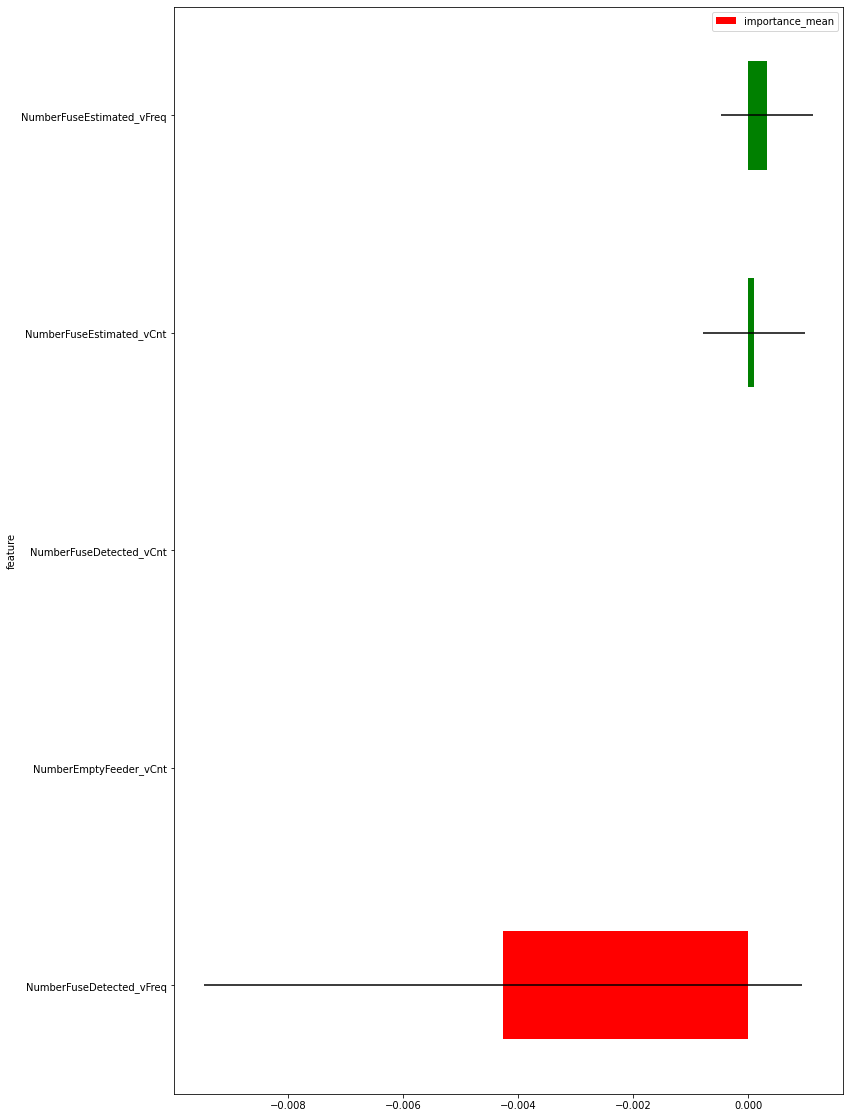

In [98]:
plot_importance(importance_df, figsize=(12, 20))

In [99]:
importance_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4
2,NumberFuseEstimated_vFreq,0.000328,0.000801,0.000126,0.001893,-0.000379,0.0,0.0
1,NumberFuseEstimated_vCnt,0.000101,0.000883,0.000252,0.001515,-0.001262,0.0,0.0
0,NumberEmptyFeeder_vCnt,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,NumberFuseDetected_vCnt,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,NumberFuseDetected_vFreq,-0.004266,0.005199,-0.004039,-0.003156,-0.014138,0.0,0.0
